## 📝 **PROYECTO FINAL**

## **INTRODUCCIÓN**

En este proyecto se pretende realizar un análisis exploratorio de datos (EDA) y la construcción de un Dashboard a partir de dos fuentes de datos relacionadas con el mundo del cine.

Los datasets seleccionados forman parte de **The Movies Dataset** de Kaggle:
- 'movies_metadata.csv' → contiene información sobre más de 45.000 películas (títulos, fehcas de estreno, presupuestos, ingresos, géneros, productoras, etc.).
- 'ratings.csv' → contiene más de 20 millones de valoraciones de usuarios sobre distintas películas.

El objetivo principal del proyecto es:
- Realizar una **limpieza profunda de ambos datasets**, ya que presentan valores nulos, inconsistencias de tipos de datos y posibles duplicados.
- **Unir ambos datasets** en un único conjunto de datos final, que cumpla con los requisitos de tamaño (mínimo 50.000 filas y 20 columnas).
- Desarrollar un **EDA** que permita extraer información de valor sobre el comportamiento de los usuarios y las características de las películas.
- Construir un **Dashboard en Power BI** para visualizar los principales insights de forma interactiva.

## **1. IMPORTACIÓNN DE LIBRERÍAS**

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import ast
from scipy import stats

sns.set_theme(style="whitegrid", palette="muted")

## **2. CARGA DE LOS DATASETS**
Cargamos los dos ficheros necesarios:
- `movies_metadata.csv`
- `ratings.csv` 

En esta primera exploración comprobaremos su tamaño y primeras filas.


In [2]:
movies = pd.read_csv("data/movies_metadata.csv", low_memory=False)
ratings = pd.read_csv("data/ratings.csv")

print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)

movies.head(2)

Movies shape: (45466, 24)
Ratings shape: (26024289, 4)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0



## **3. LIMPIEZA PROFUNDA DE movies_metadata**
Este dataset contiene información de las películas. Algunas columnas no son útiles para el análisis, otras presentan problemas de tipo de datos y existen valores nulos.  

### Pasos:
1. Eliminar columnas irrelevantes
2. Convertir tipos de datos (por ejemplo: `budget` y `revenue` como numéricos, `release_date` como fecha).
3. Eliminar duplicados y filas con `title` o `release_date` nulos.  
4. Limpiar `genres` → `main_genre` y `secondary_genre`.  
5. Limpiar `belongs_to_collection` → `collection_name`.  
6. Limpiar `production_countries` → `main_country`, `num_countries`. 


In [3]:
# Exploramos los datos

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
# Eliminamos columnas irrelevantes

movies = movies.drop(['homepage','tagline','overview'], axis=1, errors='ignore')

In [5]:
# Convertimos de tipos 

movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce').fillna(0)
movies['revenue'] = pd.to_numeric(movies['revenue'], errors='coerce').fillna(0)
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')

In [6]:
# Eliminar duplicados y nulos críticos

movies = movies.drop_duplicates(subset='id')
movies = movies.dropna(subset=['title','release_date'])

In [7]:
# Buscamos si hay duplicados y si los hay los eliminamos

movies.duplicated().sum()

movies = movies.drop_duplicates(subset='id')

In [8]:
# Tratamos los valores nulos

movies['budget'] = movies['budget'].fillna(0)
movies = movies.dropna(subset=['title','release_date'])

In [54]:
# Limpieza de 'genres' → extraer el género principal
def extraer_genero_principal(x):
    try:
        generos = ast.literal_eval(x)
        if isinstance(generos, list) and len(generos) > 0:
            return generos[0]['name']
    except:
        return "Unknown"
    return "Unknown"

movies['main_genre'] = movies['genres'].apply(extraer_genero_principal)

# Extraemos el género secundario
def extraer_genero_secundario(x):
    try:
        generos = ast.literal_eval(x)
        if isinstance(generos, list) and len(generos) > 1:
            return generos[1]['name']
    except:
        return "Unknown"
    return "Unknown"

movies['secondary_genre'] = movies['genres'].apply(extraer_genero_secundario)

In [56]:
movies[['title', 'genres', 'main_genre', 'secondary_genre']].head()

,title,genres,main_genre,secondary_genre
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Animation,Comedy
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Adventure,Fantasy
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Romance,Comedy
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Comedy,Drama
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Comedy,Unknown


In [57]:
# Eliminamos la columna 'genres' para no cargar con datos duplicados
movies = movies.drop(columns=['genres'], errors='ignore')

In [63]:
# Limpieza de belongs_to_collection
def extraer_coleccion(x):
    try:
        coleccion = ast.literal_eval(x)
        if isinstance(coleccion, dict) and 'name' in coleccion:
            return coleccion['name']
    except:
        return "No Collection"
    return "No Collection"

movies['collection_name'] = movies['belongs_to_collection'].apply(extraer_coleccion)
movies = movies.drop(columns=['belongs_to_collection'], errors='ignore')

print("Movies limpias:", movies.shape)
movies[['title','main_genre','secondary_genre','collection_name']].head()

Movies limpias: (45346, 22)


,title,main_genre,secondary_genre,collection_name
0,Toy Story,Animation,Comedy,Toy Story Collection
1,Jumanji,Adventure,Fantasy,No Collection
2,Grumpier Old Men,Romance,Comedy,Grumpy Old Men Collection
3,Waiting to Exhale,Comedy,Drama,No Collection
4,Father of the Bride Part II,Comedy,Unknown,Father of the Bride Collection


In [95]:
# Limpieza de production_countries → main_country + num_countries
def procesar_paises(x):
    try:
        paises = ast.literal_eval(x)
        if isinstance(paises, list) and len(paises) > 0:
            main = paises[0]['name']
            num = len(paises)
            return pd.Series([main, num])
    except:
        return pd.Series(["Unknown", 0])
    return pd.Series(["Unknown", 0])

movies[['main_country','num_countries']] = movies['production_countries'].apply(procesar_paises)
movies = movies.drop(columns=['production_countries'], errors='ignore')

print("Movies limpias:", movies.shape)
movies[['title','main_genre','secondary_genre','collection_name','main_country','num_countries']].head()

Movies limpias: (45346, 23)


,title,main_genre,secondary_genre,collection_name,main_country,num_countries
0,Toy Story,Animation,Comedy,Toy Story Collection,United States of America,1
1,Jumanji,Adventure,Fantasy,No Collection,United States of America,1
2,Grumpier Old Men,Romance,Comedy,Grumpy Old Men Collection,United States of America,1
3,Waiting to Exhale,Comedy,Drama,No Collection,United States of America,1
4,Father of the Bride Part II,Comedy,Unknown,Father of the Bride Collection,United States of America,1


In [97]:
# Comprobamos el tamaño de dataset

print("Movies limpias:", movies.shape)

Movies limpias: (45346, 23)


## **4. LIMPIEZA PROFUNDA DE ratings**
El dataset de valoraciones contiene millones de registros. Revisaremos su consistencia:  

### Pasos:
1. Eliminar columnas irrelevantes (`timestamp`).
2. Eliminar duplicados. 
3. Filtrar películas con al menos 100 votos.  
4. Reducir al 10% de los datos mediante muestreo estratificado por `movieId`.  


In [10]:
# Exploramos los datos

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [11]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [12]:
# Elimamos columnas irrelevantes
ratings = ratings.drop(['timestamp'], axis=1)

In [13]:
# Buscamos si hay duplicados y si los hay los eliminamos

ratings.duplicated().sum()

np.int64(0)

In [14]:
ratings = ratings.drop_duplicates()

In [15]:
# Rango de valores
print(ratings['rating'].describe())

count    2.602429e+07
mean     3.528090e+00
std      1.065443e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [16]:
# Verificamos los rangos
ratings['rating'].unique()  # valores deberían ser 0.5 a 5.0

array([1. , 4.5, 5. , 4. , 3.5, 2.5, 0.5, 3. , 2. , 1.5])

In [17]:
# Comprobamos el tamaño del dataset
print("Ratings limpios:", ratings.shape)

Ratings limpios: (26024289, 3)


In [18]:
# Filtramos por número mínimo de votos por película
counts = ratings['movieId'].value_counts()
ids_validos = counts[counts >= 100].index   
ratings_filtrado = ratings[ratings['movieId'].isin(ids_validos)]
print("Ratings filtrados (mín 100 votos):", ratings_filtrado.shape)

Ratings filtrados (mín 100 votos): (25572930, 3)


In [19]:
# Segundo filtrado, muestreo estratificado (10%) por movieID
ratings_reducido, _ = train_test_split(
    ratings_filtrado, 
    test_size=0.9, 
    stratify=ratings_filtrado['movieId'],
    random_state=42
)

print("Ratings reducidos (estratificado 10%):", ratings_reducido.shape)

Ratings reducidos (estratificado 10%): (2557293, 3)


## **5. UNION DE LOS DATASETS**

Uniremos ambos datasets utilizando como clave 'movieId' (ratings) y 'id' (movies).
El objetivo es generar un **dataset final** que combine información de películas con las valoraciones de usuarios.

In [98]:
# Aseguramos tipos compatibles

movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
ratings_reducido['movieId'] = pd.to_numeric(ratings_reducido['movieId'], errors='coerce')

# Unión
df = ratings_reducido.merge(movies, left_on='movieId', right_on='id', how='inner')
print("Dataset final:", df.shape)
df.head(2)

Dataset final: (1133767, 26)


,userId,movieId,rating,adult,budget,id,imdb_id,original_language,original_title,popularity,...,status,title,video,vote_average,vote_count,main_genre,secondary_genre,collection_name,main_country,num_countries
0,18426,6957,3.0,False,26000000.0,6957.0,tt0405422,en,The 40 Year Old Virgin,11.519662,...,Released,The 40 Year Old Virgin,False,6.2,2020.0,Comedy,Romance,No Collection,United States of America,1
1,84646,1544,3.0,False,0.0,1544.0,tt0421994,en,Imagine Me & You,6.008971,...,Released,Imagine Me & You,False,7.0,181.0,Drama,Comedy,No Collection,Germany,3


## **6. LIMPIEZA POSTERIOR A LA UNIÓN**

In [101]:
df.columns

Index(['userId', 'rating', 'adult', 'budget', 'id', 'original_language',
       'original_title', 'popularity', 'production_companies', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title',
       'vote_average', 'vote_count', 'main_genre', 'secondary_genre',
       'collection_name', 'main_country', 'num_countries'],
      dtype='object')

In [100]:
# Eliminamos las columnas redundantes
df = df.drop(columns=['movieId', 'imdb_id', 'poster_path', 'video'], errors='ignore')

In [103]:
# Rellenamos valores nulos en campos secundarios
df['production_companies'] = df['production_companies'].fillna("Unknown")

In [105]:
# Eliminamos duplicados
df = df.drop_duplicates()

In [106]:
# Filtramos películas modernas 
df = df[df['release_date'].dt.year >= 2005]

In [107]:
print("Dataset final tras limpieza:", df.shape)

Dataset final tras limpieza: (219379, 22)


## **6. ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

El objetivo de esta sección es explorar patrones e insights en el dataset final.

### **6.1 Distribución de ratings**

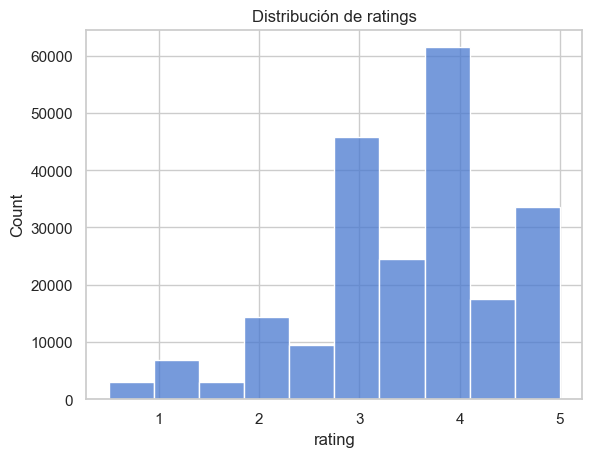

In [108]:
sns.histplot(df['rating'], bins=10)
plt.title("Distribución de ratings")
plt.show()

### **6.2 Top 10 películas con mayor número de valoraciones**

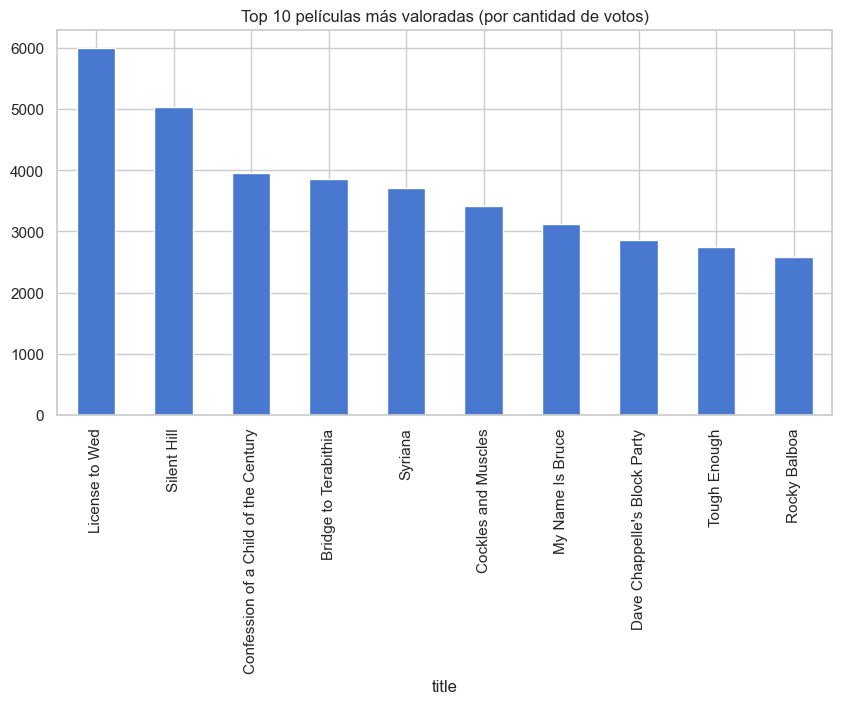

In [109]:
top_movies = df['title'].value_counts().head(10)
top_movies.plot(kind='bar', figsize=(10, 5))
plt.title("Top 10 películas más valoradas (por cantidad de votos)")
plt.show()

### **6.3 Media de ratings por género**

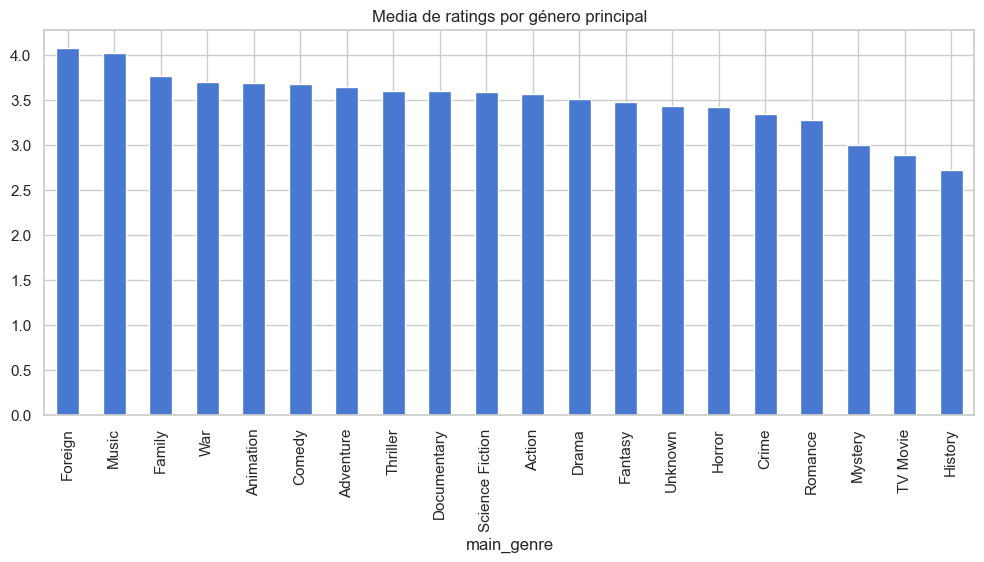

In [110]:
# Media de ratings por género principal
genre_ratings = df.groupby('main_genre')['rating'].mean().sort_values(ascending=False)
genre_ratings.plot(kind='bar', figsize=(12,5))
plt.title("Media de ratings por género principal")
plt.show()

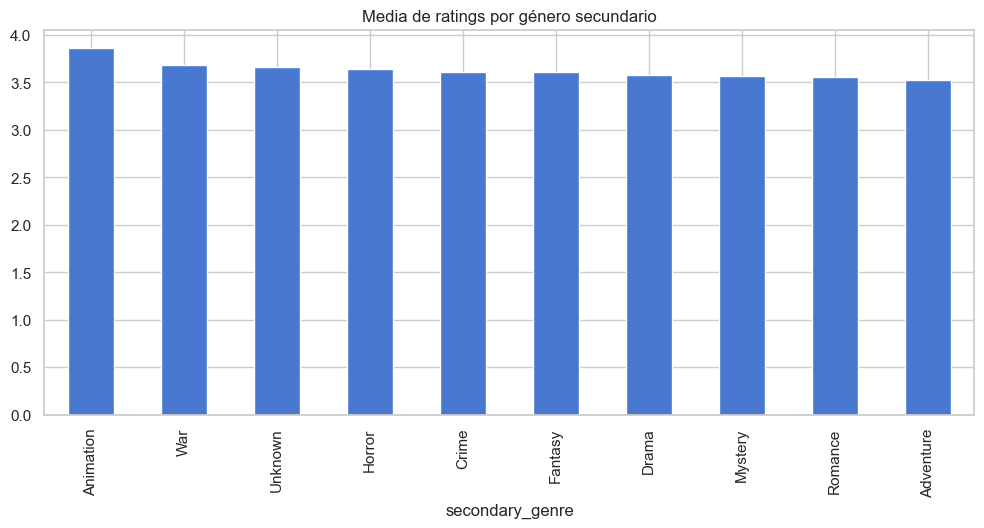

In [111]:
# Media de ratings por género secundario
secondary_ratings = df.groupby('secondary_genre')['rating'].mean().sort_values(ascending=False).head(10)
secondary_ratings.plot(kind='bar', figsize=(12,5))
plt.title("Media de ratings por género secundario")
plt.show()

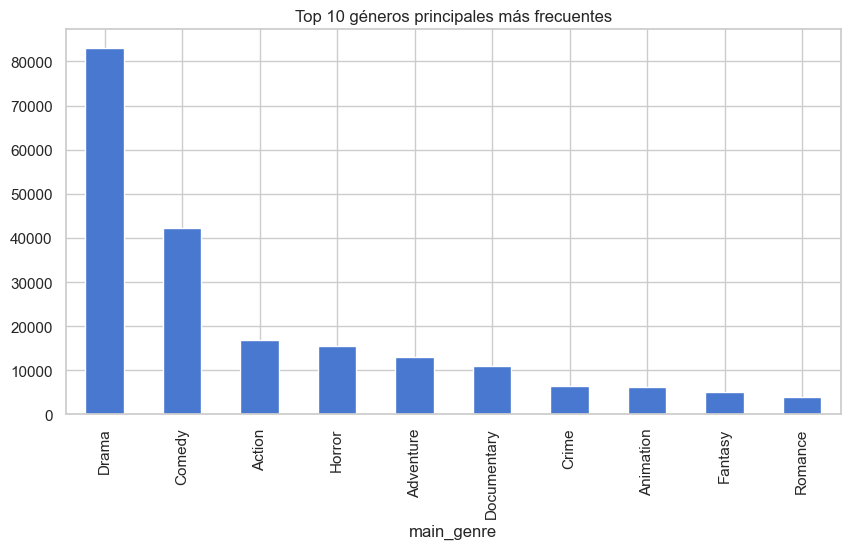

In [112]:
# Top 10 géneros principales más frecuentes
top_genres = df['main_genre'].value_counts().head(10)
top_genres.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 géneros principales más frecuentes")
plt.show()

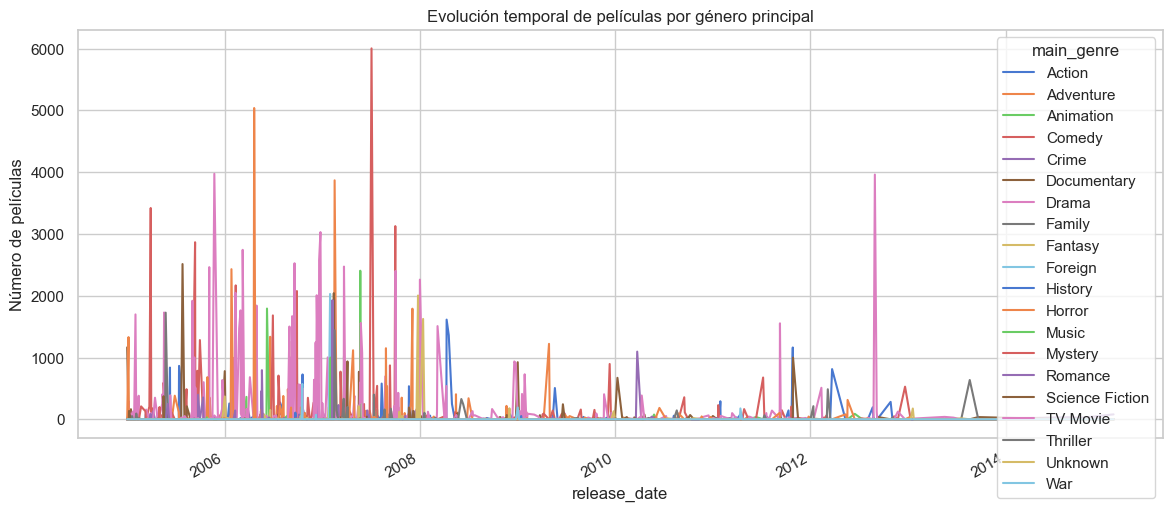

In [113]:
# Evolución temporal de películas por género principal
df.groupby(['release_date','main_genre']).size().unstack(fill_value=0).plot(figsize=(14,6))
plt.title("Evolución temporal de películas por género principal")
plt.ylabel("Número de películas")
plt.show()

### **6.4 Relación presupuesto-ingresos con las valoraciones**

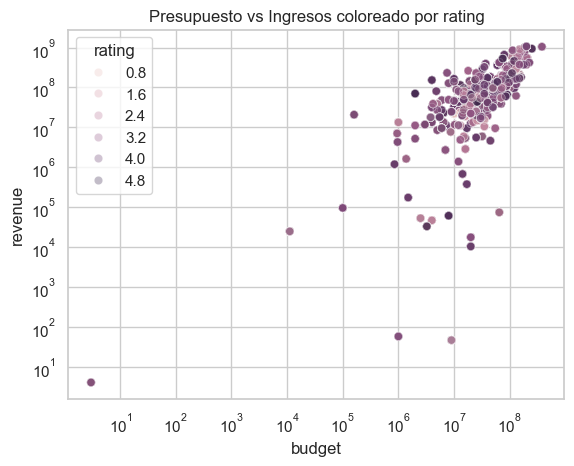

In [156]:
# Presupuesto vs ingresos vs rating
sns.scatterplot(data=df, x='budget', y='revenue', hue='rating', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title("Presupuesto vs Ingresos coloreado por rating")
plt.show()

### **6.5 Evolución de valoraciones a lo largo del tiempo**

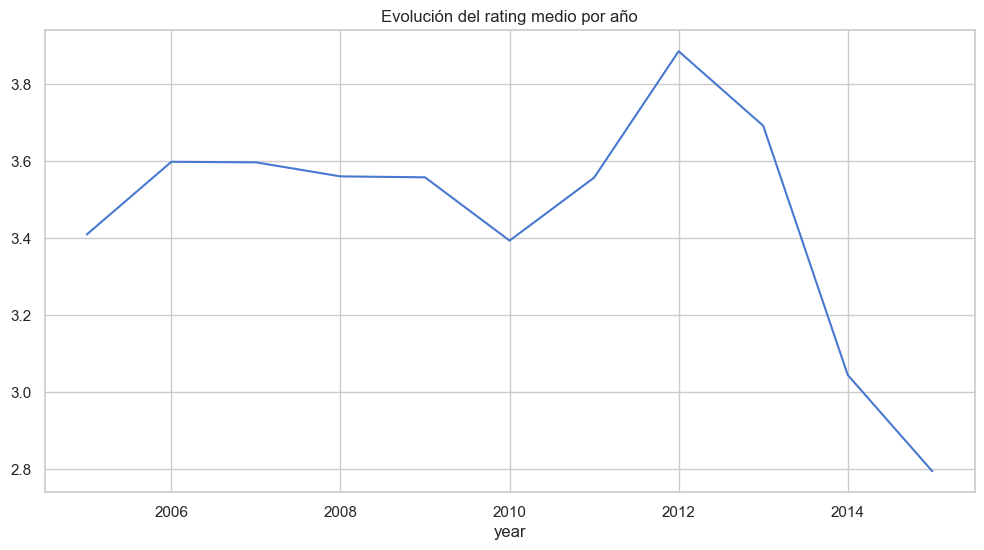

In [86]:
df['year'] = df['release_date'].dt.year
df.groupby('year')['rating'].mean().plot(figsize=(12,6))
plt.title("Evolución del rating medio por año")
plt.show()

### **6.6 Análisis de las Colecciones**

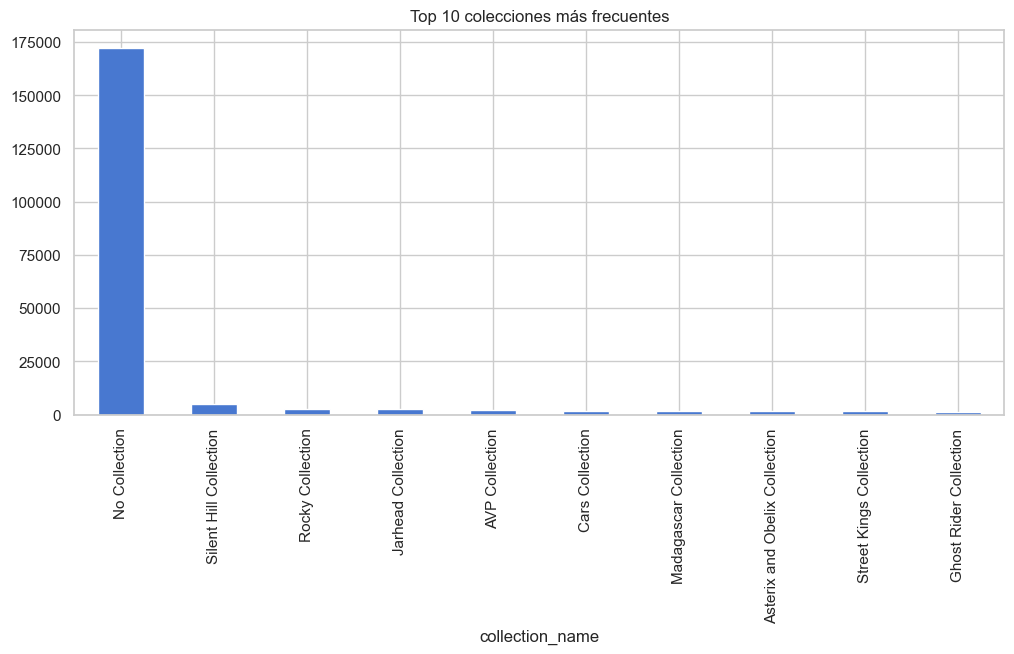

In [87]:
# Top 10 colecciones más frecuentes
top_collections = df['collection_name'].value_counts().head(10)
top_collections.plot(kind='bar', figsize=(12,5))
plt.title("Top 10 colecciones más frecuentes")
plt.show()

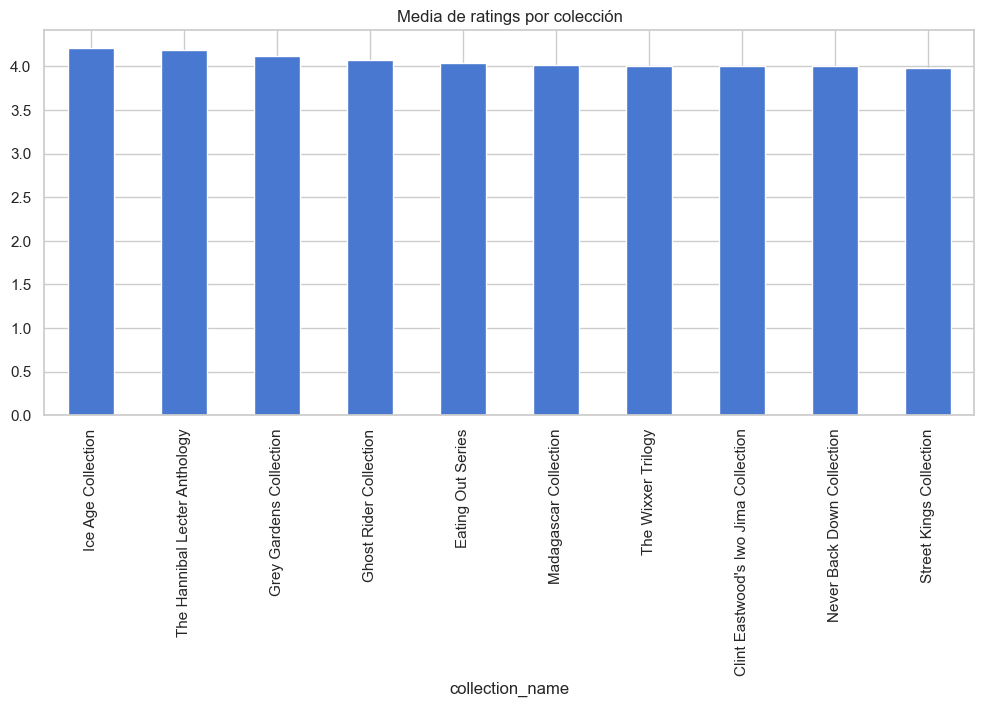

In [88]:
# Media de ratings por colección
collection_ratings = df.groupby('collection_name')['rating'].mean().sort_values(ascending=False).head(10)
collection_ratings.plot(kind='bar', figsize=(12,5))
plt.title("Media de ratings por colección")
plt.show()

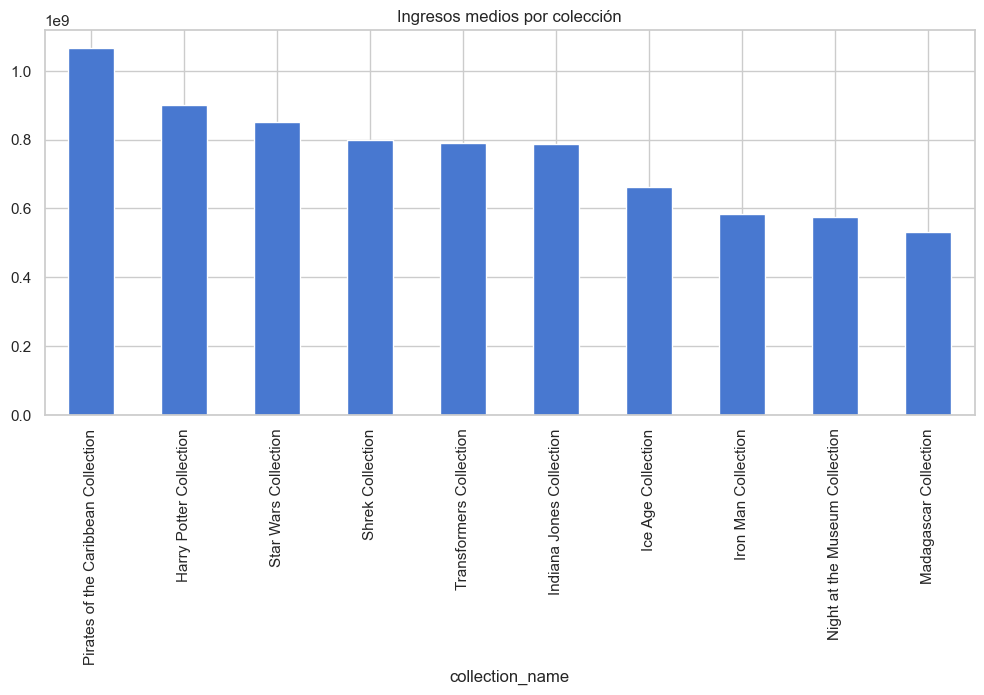

In [115]:
# Ingresos medios por colección
collection_revenue = df.groupby('collection_name')['revenue'].mean().sort_values(ascending=False).head(10)
collection_revenue.plot(kind='bar', figsize=(12,5))
plt.title("Ingresos medios por colección")
plt.show()

### **6.7 Análisis de Países**

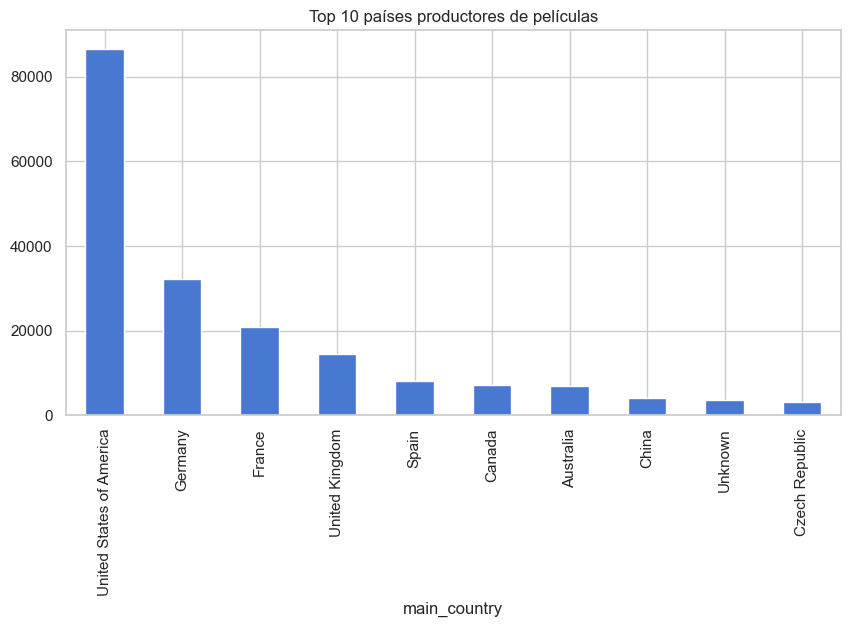

In [116]:
# Top 10 países productores de películas
top_countries = df['main_country'].value_counts().head(10)
top_countries.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 países productores de películas")
plt.show()

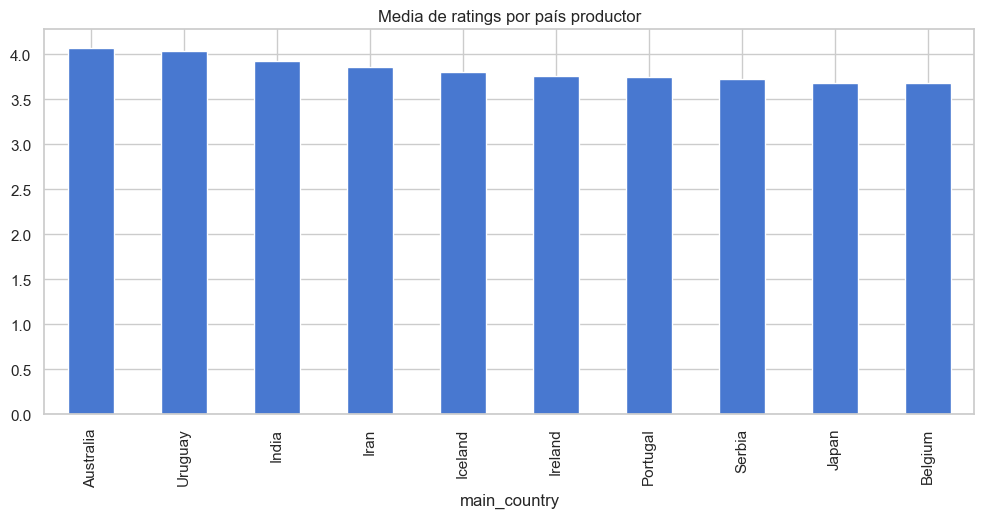

In [117]:
# Media ratings por país productor
country_ratings = df.groupby('main_country')['rating'].mean().sort_values(ascending=False).head(10)
country_ratings.plot(kind='bar', figsize=(12,5))
plt.title("Media de ratings por país productor")
plt.show()

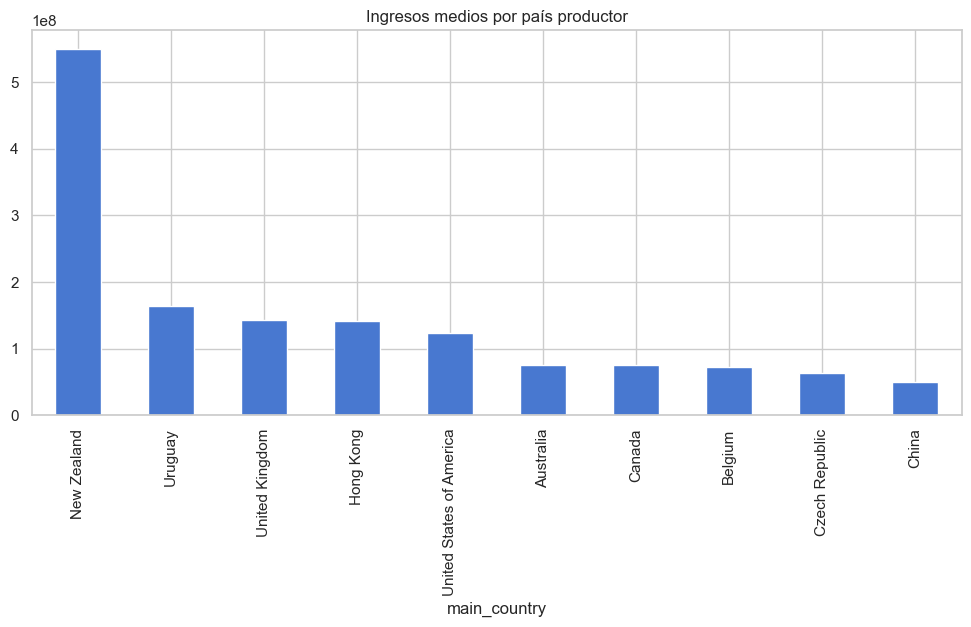

In [118]:
# Ingresos medios por país productor
country_revenue = df.groupby('main_country')['revenue'].mean().sort_values(ascending=False).head(10)
country_revenue.plot(kind='bar', figsize=(12,5))
plt.title("Ingresos medios por país productor")
plt.show()

### **6.8 Coproducciones vs producciones únicas**

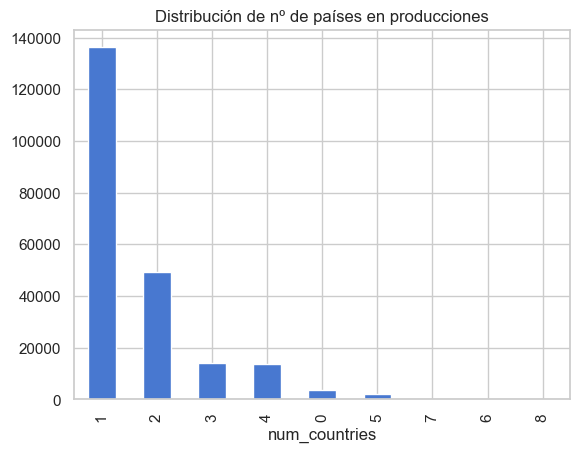

In [119]:
# Número de países en producciones
df['num_countries'].value_counts().head(10).plot(kind='bar')
plt.title("Distribución de nº de países en producciones")
plt.show()

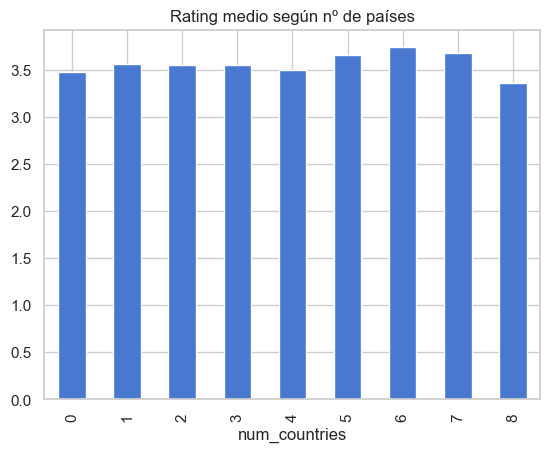

In [120]:
# Ratings según países
df.groupby('num_countries')['rating'].mean().plot(kind='bar')
plt.title("Rating medio según nº de países")
plt.show()

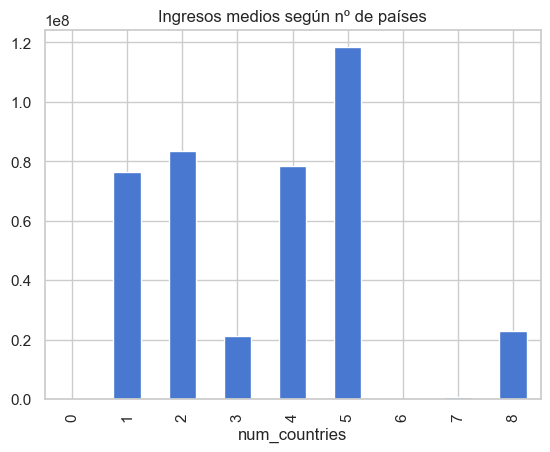

In [121]:
# Ingreses medios según el numero de paises en el que se produce
df.groupby('num_countries')['revenue'].mean().plot(kind='bar')
plt.title("Ingresos medios según nº de países")
plt.show()

## 📊 **7. ANÁLISIS FINAL / CONCLUSIONES**

### **7.1 Distribución general de Ratings**

Analizamos cómo se distribuyen las valoraciones en todo el dataset

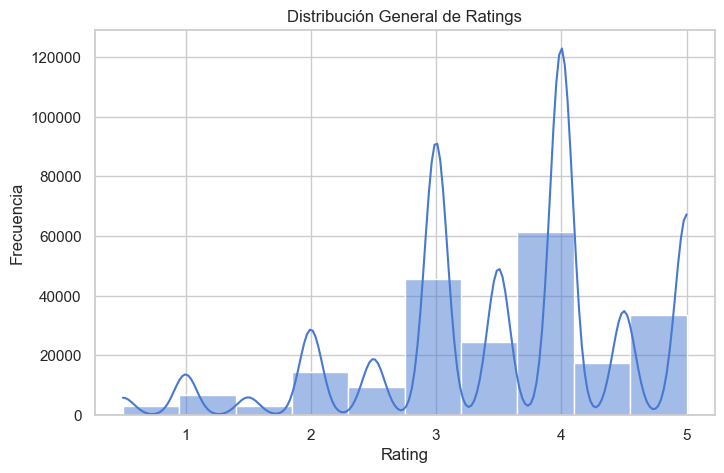

count    219379.00
mean          3.56
std           1.05
min           0.50
25%           3.00
50%           4.00
75%           4.00
max           5.00
Name: rating, dtype: float64

In [154]:
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=10, kde=True)
plt.title("Distribución General de Ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

df['rating'].describe().round(2)

🔎 *Conclusión*: La mayoría de películas se concentran en rangos medios (4, 3), con pocas películas extremadamente mal o muy bien valoradas.\
Siendo la media de las valoraciones 3.56 con una desviación estándar de ~1.05.

### **7.2 Géneros más populares y mejor valorados**

Se comparan los géneros principales en número de películas y su rating medio.

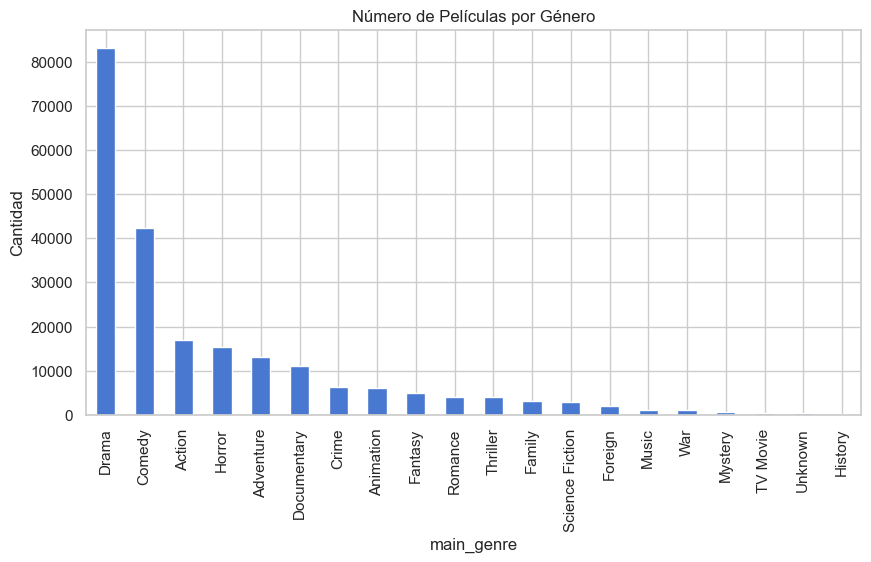

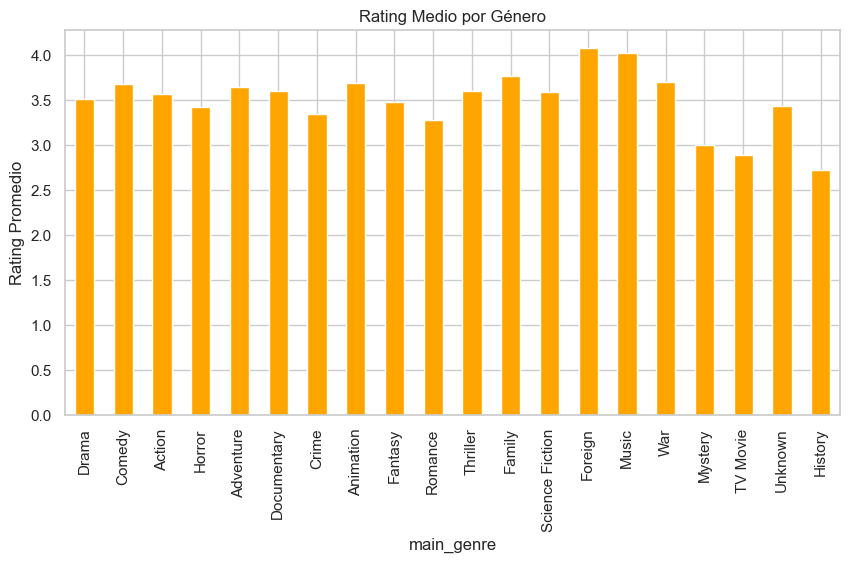

In [124]:
genre_stats = df.groupby('main_genre').agg(
    peliculas=('title', 'count'),
    rating_medio=('rating', 'mean')
).sort_values(by='peliculas', ascending=False)

genre_stats[['peliculas']].plot(kind='bar', figsize=(10,5), legend=False)
plt.title("Número de Películas por Género")
plt.ylabel("Cantidad")
plt.show()

genre_stats[['rating_medio']].plot(kind='bar', figsize=(10,5), color="orange", legend=False)
plt.title("Rating Medio por Género")
plt.ylabel("Rating Promedio")
plt.show()

🔎 *Conclusión*: Los géneros más producidos son Drama, Comedy y Action, que concentran gran parte del catálogo.\
Sin embargo, no siempre coinciden con los mejor valorados: géneros como Documentary o Animation tienden a obtener medias de rating más altas que géneros más comerciales.

### **7.3 Producción por países**

Comparación entre países con más producciones y su rating promedio.

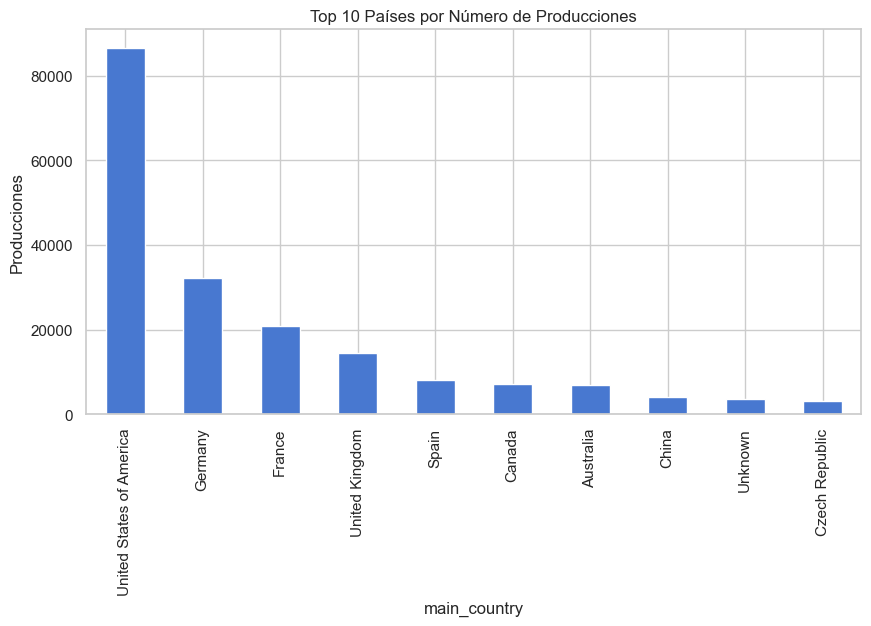

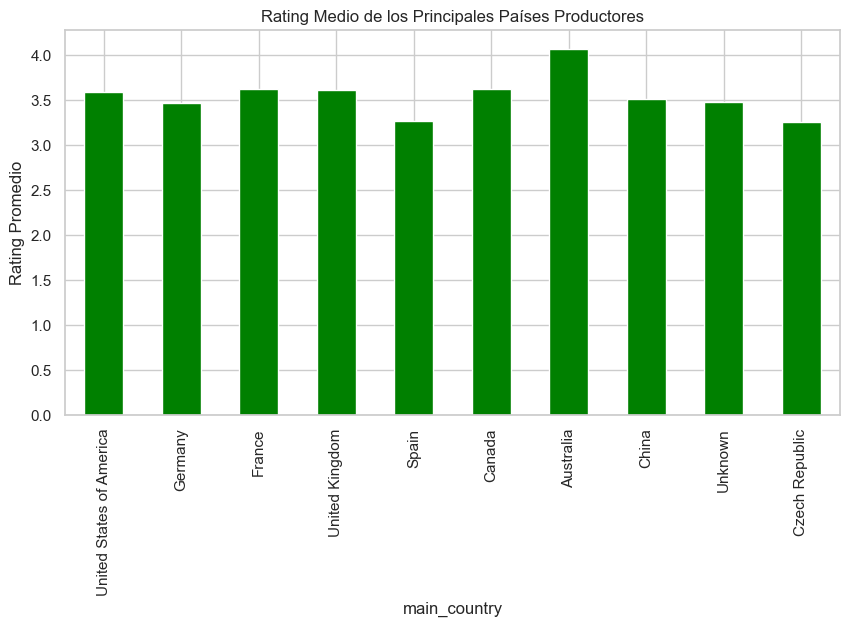

In [125]:
country_stats = df.groupby('main_country').agg(
    producciones=('title', 'count'),
    rating_medio=('rating', 'mean')
).sort_values(by='producciones', ascending=False).head(10)

country_stats[['producciones']].plot(kind='bar', figsize=(10,5), legend=False)
plt.title("Top 10 Países por Número de Producciones")
plt.ylabel("Producciones")
plt.show()

country_stats[['rating_medio']].plot(kind='bar', figsize=(10,5), color="green", legend=False)
plt.title("Rating Medio de los Principales Países Productores")
plt.ylabel("Rating Promedio")
plt.show()

🔎 *Conclusión*: **Estados Unidos** domina ampliamente en número de producciones.\
Otros países como **Reino Unido, Francia, Alemania o Canadá** aportan menor volumen, pero muestran medias de rating competitivas, lo que refleja diversidad y calidad más allá del mercado estadounidense.

### **7.4 Relación Presupuesto vs Ingreso**

Exploramos la correlación entre lo invertido y lo recaudado

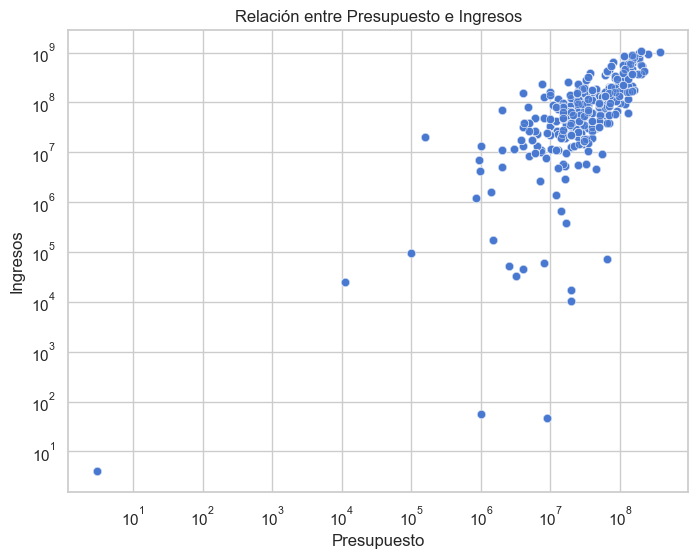

In [126]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="budget", y="revenue", alpha=0.5)
plt.title("Relación entre Presupuesto e Ingresos")
plt.xlabel("Presupuesto")
plt.ylabel("Ingresos")
plt.xscale("log")
plt.yscale("log")
plt.show()

🔎 *Conclusión*: Existe una relación positiva entre **presupuesto e ingresos**: las películas con mayor inversión tienden a recaudar más.\
No obstante, también se identifican casos de **superproducciones que no recuperan la inversión** y de **películas de bajo presupuesto con gran rentabilidad** (outliers).

### **7.5 Coproducciones vs Producciones Únicas**

En este apartado analizamos si existen diferencias relevantes entre producciones realizadas en un solo país y aquellas en coproducción internacional.

#### **Rating Promedio**

Comparamos la media de valoraciones entre coproducciones y producciones únicas.

In [145]:
df.groupby('is_coproduction')['rating'].mean().round(2)

is_coproduction
Coproducción        3.55
Producción Única    3.56
Name: rating, dtype: float64

🔎 *Conclusión*: No se observan diferencias significativas en el rating medio entre producciones únicas y coproducciones.

#### **Cantidad de películas y rating medio**

Complementamos el análisis añadiendo cuántas películas pertenencen a cada grupo.

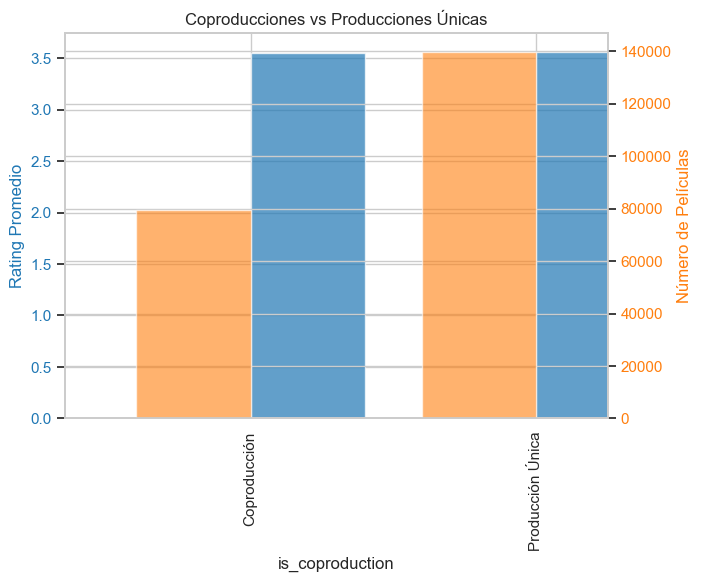

In [130]:
copro_stats = df.groupby('is_coproduction').agg(
    rating_medio=('rating','mean'),
    cantidad=('title','count')
)

fig, ax1 = plt.subplots(figsize=(7,5))

# Barras de rating
color = 'tab:blue'
ax1.set_title("Coproducciones vs Producciones Únicas")
ax1.set_ylabel("Rating Promedio", color=color)
copro_stats['rating_medio'].plot(kind='bar', ax=ax1, color=color, alpha=0.7, position=0, width=0.4)
ax1.tick_params(axis='y', labelcolor=color)

# Segundo eje: número de películas
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel("Número de Películas", color=color)
copro_stats['cantidad'].plot(kind='bar', ax=ax2, color=color, alpha=0.6, position=1, width=0.4)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

🔎 *Conclusión*: Aunque el rating medio es similar, hay una diferencia en el volumen de películas producidas en cada categoría.

#### **Ingresos promedio y Robustez**

Otra métrica interesante es el éxito económico, comparando los ingresos medios de cada grupo. Monstrando los valores exactos para evitar interpretaciones ambiguas.

In [150]:
# Diferencia de ingresos medios
vals = df.groupby('is_coproduction')['revenue'].mean()
diff_abs = vals['Producción Única'] - vals['Coproducción']
diff_pct = (diff_abs / vals['Coproducción']) * 100
print(f"Diferencia PU - CPRO: {diff_abs/1e6:.2f}M USD ({diff_pct:.2f}%)")

Diferencia PU - CPRO: 2.42M USD (3.35%)


In [ ]:
# Robustez: Media, mediana y media recortada
df.groupby('is_coproduction')['revenue'].agg(
    media='mean',
    mediana='median',
    media_recortada=lambda x: x.clip(upper=x.quantile(0.99)).mean()
).round(2)

,media,mediana,media_recortada
is_coproduction,,,
Coproducción,72156801.00,18618284.0,68901375.40
Producción Única,74572914.36,173066.0,72454788.71


🔎 *Conclusión*: Las producciones únicas **presentan ingresos promedio ligeramente superiores a las coproducciones (+2.42M, +3.35%)**.

Al comprobar la robustez concluimos:
* En la mediana, las coproducciones superan claramente a las producciones únicas (18.6M vs 0.17M).
* En la media recortada, las producciones únicas mantienen una ligera ventaja (72.4M vs 68.9M).

Esto refleja que muchas producciones únicas tienen ingresos muy bajos, mientras que las coproducciones suelen asegurar un rango intermedio más sólido.

#### **ROI (rentabilidad)**

Comparamos la rentabilidad

In [147]:
df_roi = df[(df['budget'] > 0) & (df['revenue'] > 0)].copy()
df_roi['roi'] = df_roi['revenue'] / df_roi['budget']
df_roi.groupby('is_coproduction')['roi'].agg(media='mean', mediana='median').round(2)

,media,mediana
is_coproduction,,
Coproducción,2.19,1.98
Producción Única,3.84,2.59


🔎 *Conclusión:* Las **producciones únicas presentan un ROI más alto** (media 3.84 vs 2.19; mediana 2.59 vs 1.98).\
Esto significa que, en promedio, aprovechan mejor la inversión que las coproducciones.


#### **Significancia estadística (log-ingresos)**

Hacemos un test rápido sobre **log(revenue)** para estabilizzar varianza.

In [143]:
tmp = df[df['revenue'] > 0].copy()
tmp['log_rev'] = np.log(tmp['revenue'])

g1 = tmp.loc[tmp['is_coproduction']=="Coproducción", 'log_rev'].dropna()
g2 = tmp.loc[tmp['is_coproduction']=="Producción Única", 'log_rev'].dropna()

t, p = stats.ttest_ind(g1, g2, equal_var=False)
print(f"t = {t:.2f}, p-value = {p:.4f}")


t = 50.03, p-value = 0.0000


🔎 *Conclusión:* El test arroja **p ≈ 0.0000 (< 0.05)**, lo que confirma que la diferencia entre ambos grupos en ingresos log-transformados es **estadísticamente significativa**.\
En este dataset, las **producciones únicas presentan ingresos significativamente mayores** que las coproducciones.

### ✅ **CONCLUSIONES GLOBALES DEL PROYECTO**

* La distribución de ratings está concentrada en valores intermedios, con pocas películas en extremos.
* Los géneros más abundantes no siempre son los mejores valorados; destacan **Animation y Documentary** en ratings.
* Estados Unidos concentra la mayoría de producciones, pero otros países muestran competitividad en calidad.
* El presupuesto influye en los ingresos, pero no garantiza el éxito: hay outliers en ambos sentidos.
* En coproducciones vs producciones únicas:
    - **Producciones únicas** → mejores en ingresos promedio, media recortada, ROI y significancia estadística.
    - **Coproducidas** → superiores en la media de ingresos, lo que indica que suelen garantizar resultados más estables, aunque con menor rentabilidad media.

Este análisis confirma la importanica de considerar tanto métricas absolutas como relativas (ROI) y medias robustas (mediana, log-ingresoos) para obtener una visión equilibrada del mercado cinematográfico.


## 🧾 **Informe Explicativo del Análisis**

Este notebook constituye el **informe completo del proyecto de análisis de datos**, integrando todas las fases del proceso analítico de manera explicativa y secuencial.

A lo largo del documento se incluyen:

- **Transformación y limpieza profunda de los datos:**  
  Se eliminaron duplicados, valores nulos y columnas innecesarias.  
  Se realizaron transformaciones en variables clave (géneros, países, colecciones, presupuestos e ingresos) para asegurar coherencia y calidad en el dataset final.  

- **Análisis descriptivo y exploratorio:**  
  Se examinaron distribuciones de ratings, géneros, países y tendencias temporales.  
  Cada gráfico se acompañó de una breve interpretación para facilitar la lectura y comprensión de los resultados.

- **Análisis estadístico y comparativo:**  
  Se exploraron relaciones entre variables económicas (presupuesto, ingresos, ROI) y se evaluaron diferencias significativas entre tipos de producción (únicas y coproducciones).  
  Se aplicaron medidas robustas (media recortada, mediana, log-transformación) para garantizar conclusiones sólidas frente a valores extremos.

- **Visualización y síntesis:**  
  Las gráficas permiten interpretar de forma visual las conclusiones más relevantes del conjunto de datos, facilitando la extracción de insights sobre el rendimiento y la rentabilidad del sector cinematográfico.

- **Conclusiones globales:**  
  El análisis evidencia que los géneros y países con mayor volumen de producción no siempre coinciden con los mejor valorados, y que las producciones únicas, aunque más variables, logran en promedio mejores resultados económicos y de rentabilidad.



## **9. EXPORTACIÓN DEL DATASET FINAL**

Exportar el dataset final ya limpio y unido para crear el Dashboard en Power BI

In [144]:
df.to_csv("data/movies_final.csv", index=False)